## Etopo1 Map of Tasmania

In the previous worked example, we showed how to grab a region from a global elevation dataset, postprocess it to eliminate local minima and save the result to a geotiff in the same form as the original dataset. 

Here we assume that we have been through this process for the island of Tasmania (the southernmost state of Australia). We will analyse the resulting elevation model and show how to locate catchments and various metrics for the topography.

In [1]:
from osgeo import gdal

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import quagmire
from quagmire import tools as meshtools
from quagmire import function as fn

from scipy.ndimage.filters import gaussian_filter

ModuleNotFoundError: No module named 'quagmire'

In [2]:
file = "data/TasmaniaETOPO1-quagmire.tif"
ds = gdal.Open(file)

band = ds.GetRasterBand(1)
height = band.ReadAsArray()
[cols, rows] = height.shape

left, hres, n0, top, n1, vres = ds.GetGeoTransform()
right = left+rows*hres
bottom = top+cols*vres
x,y = np.meshgrid(np.arange(left, right, hres), np.arange(top,  bottom, vres))

map_extent = ( left, right, bottom, top)

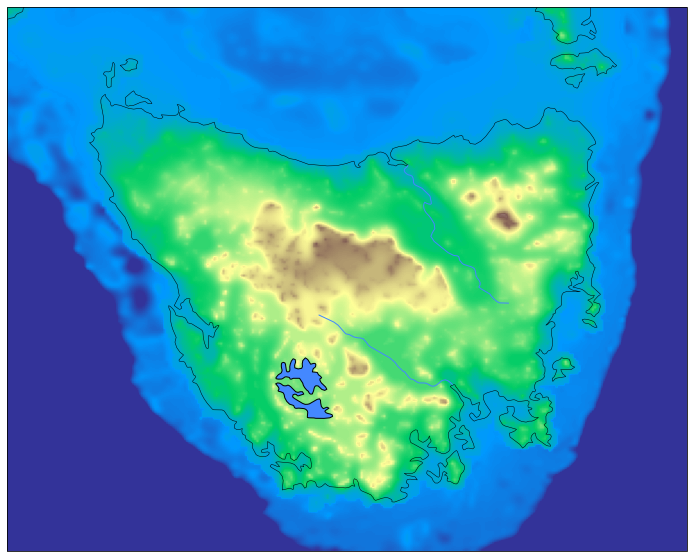

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                           edgecolor=(1.0,0.8,0.0),
                           facecolor="none")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                           edgecolor="green",
                           facecolor="blue")

lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                           edgecolor="green",
                           facecolor="#4488FF")

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',
                           edgecolor="#4488FF",
                           facecolor="blue")

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)
ax.add_feature(lakes,     edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(rivers   , facecolor="none", linewidth=1, zorder=3)

plt.imshow(height, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='terrain', origin='upper', vmin=-400., vmax=2000.)

In [4]:
# filter out points we do not want

point_mask = height > -100.0
x1s = x[point_mask]
y1s = y[point_mask]
heights = height[point_mask]

submarine = (heights <  0.0 )
subaerial = (heights >= 0.0 )

## now be more specific and locate points adjacent to the coastline

import stripy
mesh0 = stripy.cartesian.Triangulation(x1s, y1s, permute=True, tree=True)
d, n  = mesh0.nearest_vertices(mesh0.points[submarine][:,0], mesh0.points[submarine][:,1], k=25)

candidates = np.where(np.any(subaerial[n],axis=1))
keepers = n[candidates,0]

boundary = np.zeros_like(subaerial)
boundary[keepers] = True

## And now replace the filtered arrays 

point_mask2 = np.zeros_like(point_mask)
point_mask2[point_mask] = subaerial | boundary

heights = height[point_mask2]
xs = x[point_mask2]
ys = y[point_mask2]
bmask2 = subaerial[subaerial | boundary] 

In [5]:
DM = meshtools.create_DMPlex_from_points(xs, ys, bmask=bmask2)
mesh = quagmire.QuagMesh(DM, downhill_neighbours=1)

NameError: name 'meshtools' is not defined

In [6]:
with mesh.deform_topography():
    mesh.topography.data = heights

NameError: name 'mesh' is not defined

In [7]:
low_points1 = mesh.identify_low_points()
low_point_coords1 = mesh.coords[low_points1] 
print(low_points1.shape)

cumulative_flow_1 = mesh.upstream_integral_fn(mesh.topography**2).evaluate(mesh)
topography_1 = mesh.topography.data[:]

outflow_points1 = mesh.identify_outflow_points()
upstream_area1 = mesh.upstream_integral_fn(fn.misc.levelset(mesh.topography, 0.0)).evaluate(mesh)

NameError: name 'mesh' is not defined

NameError: name 'low_points1' is not defined

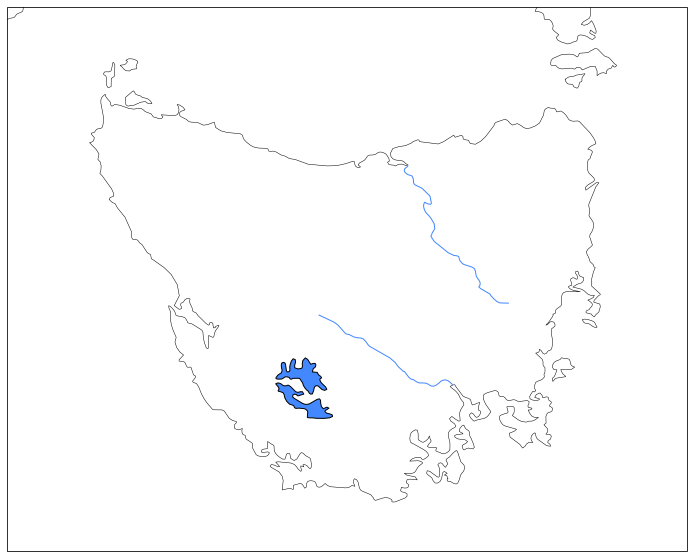

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                           edgecolor=(1.0,0.8,0.0),
                           facecolor="none")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                           edgecolor="green",
                           facecolor="blue")

lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                           edgecolor="green",
                           facecolor="#4488FF")

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',
                           edgecolor="#4488FF",
                           facecolor="blue")

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)
ax.add_feature(lakes,     edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(rivers   , facecolor="none", linewidth=1, zorder=3)

ax.scatter(xs[low_points1], ys[low_points1], color="Red")
ax.scatter(xs[~bmask2], ys[~bmask2], color="Grey", marker='x')

plt.imshow(height, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='terrain', origin='upper', vmin=-400., vmax=2000.)

In [9]:
cumulative_flow_3 = mesh.upstream_integral_fn(mesh.topography**2).evaluate(mesh)
low_points3 = mesh.identify_low_points()
topography_3 = mesh.topography.data[:]
print("Low points - {}".format(low_points3.shape))

NameError: name 'mesh' is not defined

In [10]:
outflow_points3 = np.unique(np.hstack(( mesh.identify_outflow_points(), mesh.identify_low_points())))
upstream_area3 = mesh.upstream_integral_fn(fn.misc.levelset(mesh.topography, 0.0)).evaluate(mesh)

NameError: name 'mesh' is not defined

In [11]:
logplot = np.log10(upstream_area3)
flows_img3 = logplot.min() * np.ones_like(point_mask2)
flows_img3[point_mask2] = logplot

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(lakes,     edgecolor="black", facecolor="none", linewidth=1, zorder=3)
ax.add_feature(rivers   , edgecolor="Yellow", facecolor="none", linewidth=1, zorder=3)

plt.imshow(flows_img3, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Blues', origin='upper', vmin=-3.5, vmax=-1.5)

ax.scatter(xs[outflow_points3], ys[outflow_points3], color="Green", s=1.0)
ax.scatter(xs[low_points3], ys[low_points3], color="Red", s=5.0)

# plt.imshow(hdiff, extent=map_extent, transform=ccrs.PlateCarree(),
#            cmap='Greens', origin='upper', vmin=0.0, vmax=200, alpha=0.25)

plt.savefig("WEx2-Flowpath-3.png", dpi=250)

NameError: name 'upstream_area3' is not defined

In [12]:
topomask = mesh.add_variable("topomask")
topomask.data = np.where(mesh.topography.data > 0.0, 1.0, 0.0)
area = mesh.upstream_integral_fn(topomask).evaluate(mesh)

# log_catchment_areas = np.sort(1.0e-10+np.log(area[outflow_points3]))[::-1]
catchment_areas = np.sort(area[outflow_points3])[::-1]
cum_catchment_areas = np.cumsum(catchment_areas)
total_area = mesh.area.sum()

plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.set_xlim(0,50)
ax.plot(100.0*cum_catchment_areas/total_area)
ax.bar(x=range(0,catchment_areas.shape[0]), height=100.0*catchment_areas/catchment_areas[0])

NameError: name 'mesh' is not defined

In [13]:
ordered_catchments = np.argsort(area[outflow_points3])[::-1]
catchments = mesh.add_variable(name="catchments")
catchments.data = mesh.uphill_propagation(points = outflow_points3[ordered_catchments[0:100]], values=np.indices((100,)), fill=-1.0, its=500)

NameError: name 'area' is not defined

In [14]:
catch = []
for i in range(0,100):
    catch.append( np.where(catchments.data==i) )

NameError: name 'catchments' is not defined

In [15]:
for i in range(0,10):
    print(catch[i][0].shape, area[outflow_points3[ordered_catchments[i]]])

IndexError: list index out of range

In [16]:
catch_img3 = -2.0 * np.ones_like(point_mask2)
catch_img3[point_mask2] = catchments.data

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(lakes,     edgecolor="black", facecolor="none", linewidth=1, zorder=3)
ax.add_feature(rivers   , edgecolor="Yellow", facecolor="none", linewidth=1, zorder=3)

for i in range(0,15):
    ax.scatter(xs[catch[i]], ys[catch[i]], s=20, alpha=0.5)

ax.scatter(xs[outflow_points3], ys[outflow_points3], color="Green", s=1.0)
ax.scatter(xs[low_points3], ys[low_points3], color="Red", s=5.0)

plt.imshow(flows_img3, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Blues', origin='upper', vmin=-3.5, vmax=-1.5, alpha=0.5, zorder=10)

plt.savefig("WEx2-15Catchments.png", dpi=250)

NameError: name 'catchments' is not defined